# Решение турнирной задачи внутри отдела

## 1. Введение

Представлен датасет, содержащий различных комментарии, кластеризованные в зависимости от содержания на токсичные и нейтральные.
<br>

Необходимо составить модель ML, определяющая комментарий к той или иной группе.

Ключевая метрика - f1-мера

------

## 2. Первичное знакомство с данными

Установка библиотек (опционально, при отсутствии):

In [1]:
# pip install pandas seaborn matplotlib nltk tabulate scikit-learn plotly keras tensorflow gensim wordcloud
# nltk.download('wordnet')
# nltk.download('punkt')

Импорт библиотек:

In [144]:
import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import nltk

from tabulate import tabulate
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.probability import FreqDist

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier

Считываем файл CSV:

In [2]:
PATH = 'toxic_comments.csv'

In [3]:
df_init = pd.read_csv(PATH)

Выведем первые и последние 5 строк:

In [4]:
df_init.head()

,Unnamed: 0,text,toxic
0,0,Explanation\r\nWhy the edits made under my use...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\r\nMore\r\nI can't make any real suggestions...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
df_init.tail()

,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \r\n\r\nThat...,0
159289,159448,"Spitzer \r\n\r\nUmm, theres no actual article ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\r\nAnd ... I really don't think you understa...",0


Выведем основную информацию о датафрейме:

In [6]:
df_init.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [7]:
df_init.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,159292.0,79725.697242,46028.837471,0.0,39872.75,79721.5,119573.25,159450.0
toxic,159292.0,0.101612,0.302139,0.0,0.00,0.0,0.00,1.0


Проверим наличие пропусков данных:

In [8]:
df_init.isna().sum()

Unnamed: 0    0
text          0
toxic         0
dtype: int64

Проверим наличие дубликатов:

In [9]:
df_init.duplicated().mean()

0.0

**Выводы:**

- Данные состоят только из трех столбцов
- Столбец `Unnamed:0` на первый взгляд не содержит полезной информации
- Данные не содержат дубликатов
- Комментарии содержат большое количество символов и слов, не несущих смысловой нагрузки

----

## 3. Первичный исследовательский анализ

### 3.1 Предобработаем исходные данные:

In [10]:
df = df_init.copy()

Удалим ненужные столбцы:

In [11]:
df = df.drop(labels=['Unnamed: 0'], axis=1).copy()

Обработаем текст комментариев:
* Приведем его к нижнему регистру
* Удалим знаки пунктуации
* Удалим стоп-слова
* Проведем лемматизацию

In [20]:
def clean_text(text):
    text = text.lower()
    
    text = re.sub(r'[^\w\s]', '', text)
    
    stop_words = set(stopwords.words('english') + list(string.ascii_lowercase))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    cleaned_text = ' '.join(words)  
    return cleaned_text

In [21]:
df['cleaned_comment'] = df['text'].apply(clean_text)

### 3.2 Подготовим даные

Теперь, когда наши входные данные стали более разумными, давайте преобразуем их так, чтобы наша модель могла их понять:
* Токенизация предложений в список отдельных слов
* Изучение свойств получившегося датасета
* Создание тестового и обучающего сета 

токенизируем предложения:

In [22]:
tokenizer = RegexpTokenizer(r'\w+')
df["tokens"] = df["cleaned_comment"].apply(tokenizer.tokenize)

посмотрим на получившийся результат:

In [23]:
df.head()

,text,toxic,cleaned_comment,tokens
0,Explanation\r\nWhy the edits made under my use...,0,explanation edits made username hardcore metal...,"[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,0,daww match background colour im seemingly stuc...,"[daww, match, background, colour, im, seemingl..."
2,"Hey man, I'm really not trying to edit war. It...",0,hey man im really trying edit war guy constant...,"[hey, man, im, really, trying, edit, war, guy,..."
3,"""\r\nMore\r\nI can't make any real suggestions...",0,cant make real suggestion improvement wondered...,"[cant, make, real, suggestion, improvement, wo..."
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page thats,"[sir, hero, chance, remember, page, thats]"


### 3.3 Изучим детальнее наш датасет

Посмотрим на баланс классов:

In [24]:
df.groupby("toxic").count()

,text,cleaned_comment,tokens
toxic,,,
0,143106,143106,143106
1,16186,16186,16186


*Видим явный дисбаланс классов с избыточной выборкой "не токсичных" комментариев.*

#### Выведем информацию о комментариях:

In [27]:
all_words = [word for tokens in df["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df["tokens"]]
vocab = sorted(list(set(all_words)))
print(f"Всего {len(all_words)} слов\nУникальных токенов словаре: {len(vocab)}\nНаибольшая длина комментария: {max(sentence_lengths)}")

Всего 5550785 слов
Уникальных токенов словаре: 239367
Наибольшая длина комментария: 1250


Построим распределение длины комментариев:

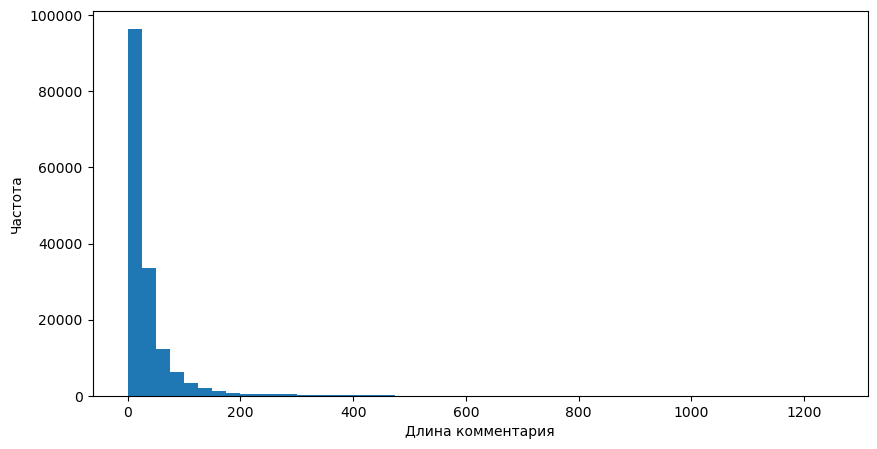

In [28]:
fig = plt.figure(figsize=(10, 5)) 
plt.xlabel('Длина комментария')
plt.ylabel('Частота')
plt.hist(sentence_lengths, bins=50)
plt.show()

**Создадим список слов, встречающихся в токсичных комментариях и не токсичных и оценим их размер:**

In [35]:
words_from_toxic_comments = [word for word_list in df[df['toxic'] == 1]\
                             ['tokens'].values for word in word_list]

words_from_clear_comments = [word for word_list in df[df['toxic'] == 0]\
                             ['tokens'].values for word in word_list]

In [40]:
print(f'Длина списка слов с токсичными комментариями: {len(words_from_toxic_comments)}')
print(f'Длина списка слов с не токсичными комментариями: {len(words_from_clear_comments)}')
print(f'Соотношение списков: {len(words_from_toxic_comments)/len(words_from_clear_comments)}')
print(f"Соотношение комментариев: {len(df.loc[df['toxic'] == 1]) / len(df.loc[df['toxic'] == 0])}")


Длина списка слов с токсичными комментариями: 463922
Длина списка слов с не токсичными комментариями: 5086863
Соотношение списков: 0.09120001855760614
Соотношение комментариев: 0.11310497114027364


*Соотношение похоже на пропорцию распределения самих комментариев, поэтому нельзя сказать, что токсичные комментарии в среднем однозначно длиннее или короче, чем не токсичные*

**Рассмотрим уникальность слов в разных типах комментариев:**

In [42]:
fdist_toxic = FreqDist(words_from_toxic_comments)
fdist_clear = FreqDist(words_from_clear_comments)
fdist_all = FreqDist(words_from_toxic_comments + words_from_clear_comments)

In [44]:
print(f'Токсичные комментарии: {len(fdist_toxic)} \nНе токсичные комментарии: {len(fdist_clear)}\nВсе комментарии: {len(fdist_all)}')

Токсичные комментарии: 36984 
Не токсичные комментарии: 227134
Все комментарии: 239367


*Уникальных слов в токсичных комментах много раз меньше, это можно объяснить комплексно, как меньшим количеством* 

**Самые популярные слова:**

In [63]:
fdists = [fdist_toxic, fdist_clear, fdist_all]
titles = ['Токсичные', 'Не токсичные', 'Все']

for fdist, title in zip(fdists, titles):
    print(title + ' комментарии:')
    print('{:<12}{:<7}'.format('Слово', 'Частота'))
    for (word, freq) in fdist.most_common(10):
        print('{:<12}{:>5}'.format(word + ':', freq))
    print('\n')

Токсичные комментарии:
Слово       Частота
fuck:        8733
suck:        4489
like:        3885
dont:        3877
shit:        3664
wikipedia:   3473
nigger:      3423
fucking:     3222
go:          3074
page:        2812


Не токсичные комментарии:
Слово       Частота
article:    70684
page:       53437
wikipedia:  31968
talk:       30138
please:     28533
one:        28108
would:      28005
like:       24170
dont:       22155
source:     20804


Все комментарии:
Слово       Частота
article:    72778
page:       56249
wikipedia:  35441
talk:       31537
one:        29843
please:     29557
would:      29154
like:       28055
dont:       26032
see:        21641




**Отобразим наглядно:**

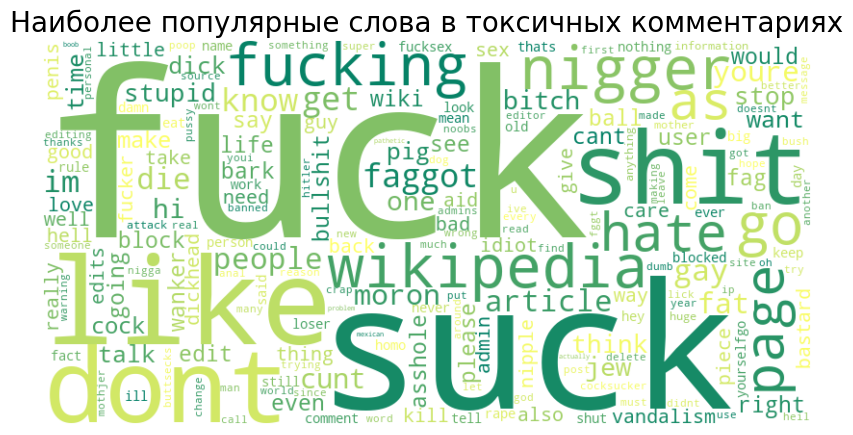

In [84]:
wordcloud = WordCloud(width=800, height=400, colormap = 'summer', background_color ='white').generate_from_frequencies(fdist_toxic)
titles = ['токсичных', 'чистых']
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Наиболее популярные слова в токсичных комментариях', fontsize=20)
plt.show()

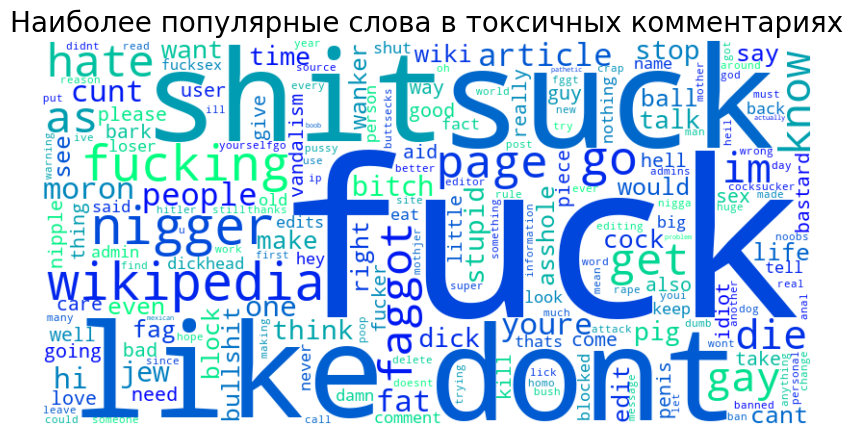

In [82]:
wordcloud = WordCloud(width=800, height=400, colormap = 'winter', background_color ='white').generate_from_frequencies(fdist_toxic)
titles = ['токсичных', 'чистых']
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Наиболее популярные слова в токсичных комментариях', fontsize=20)
plt.show()

**Распределение слов по частоте:**

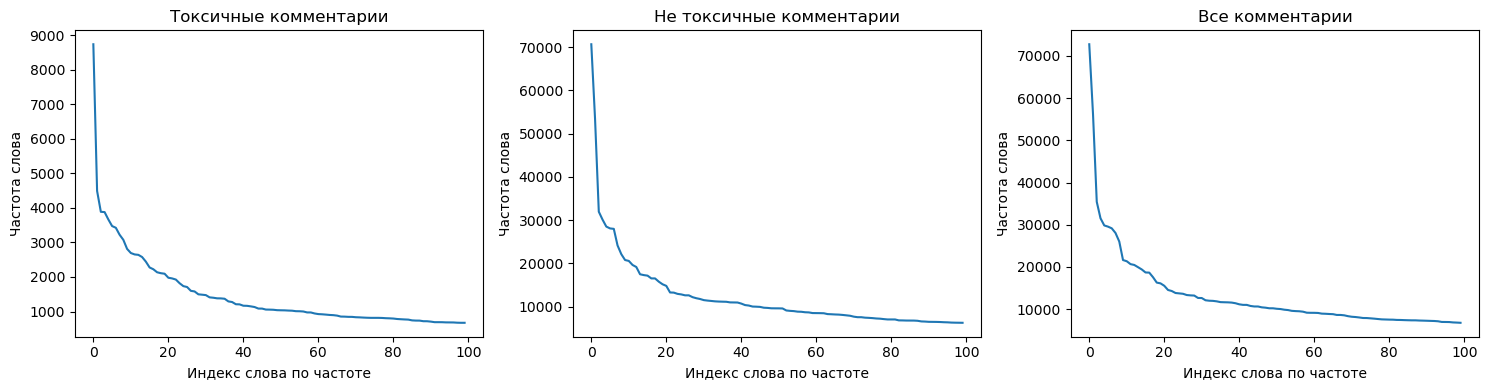

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

for i, (fdist, title) in enumerate(zip(fdists, titles)):
    ax[i].plot(sorted(fdist.values(), reverse=True)[:100])
    ax[i].set(xlabel='Индекс слова по частоте', ylabel='Частота слова', title=title + ' комментарии')

plt.tight_layout()

*Видим обратно пропорциональную зависимость*

### Выводы

1. Комментарии выглядят вполне естественно. Датасет отражает натуральное поведение интернет-комментариев<br><br>
2. Ярковыраженных аномалий не выявлено<br><br>
3. Среди комментариев преобладает дисбаланс классов в пользу не токсичных комментариев

-------

### 4. Перейдем непорседственно к машинному обучению:

Естественным способом представления текста для компьютеров является кодирование каждого символа отдельно, однако это кажется крайне неадекватным для представления и понимания языка. Нашей целью является создание полезного встраивания для каждого предложения в нашем наборе данных, а затем использование этих встраиваний для точного предсказания соответствующей категории.

Самый простой подход, с которого мы можем начать, - это использование модели "мешка слов" (bag of words) и применение логистической регрессии сверху. Модель "мешка слов" просто сопоставляет индекс каждому слову в нашем словаре и встраивает каждое предложение в список из 0, с 1 в каждом индексе, соответствующем слову, присутствующему в предложении.

### 4.1 Моделирование

Разобьем данные на обучающую и тестовую выборку в пропорции 80:20%:

In [87]:
X = df["cleaned_comment"]
y = df["toxic"]

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

Убедимся в корректности разбиения:

In [89]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((127433,), (31859,), (127433,), (31859,))

Векторизируем данные:

In [90]:
def vectorize_text_data(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

In [91]:
X_train_counts, count_vectorizer = vectorize_text_data(X_train)
X_test_counts = count_vectorizer.transform(X_test)

Визуализируем в 2 мерную проекцию:

In [126]:
def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Не токсичные')
            green_patch = mpatches.Patch(color='blue', label='Токсичные')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

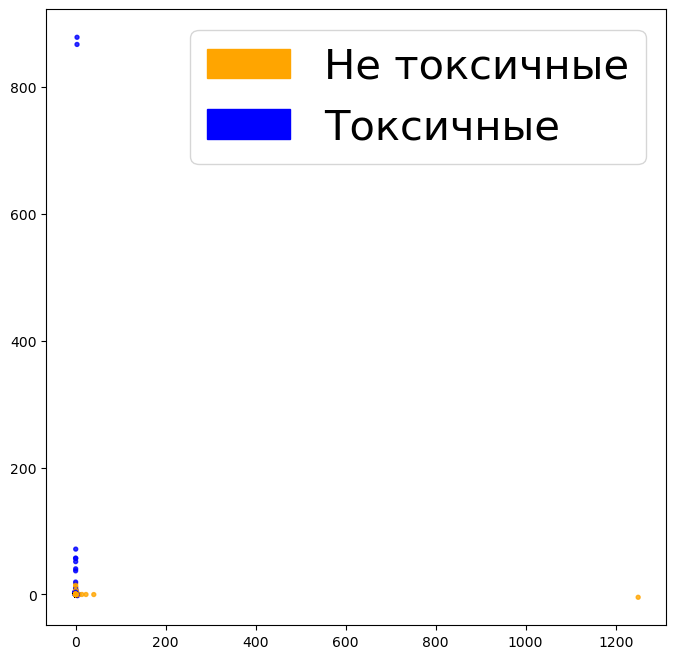

In [127]:
fig = plt.figure(figsize=(8, 8))          
plot_LSA(X_train_counts, y_train)
plt.show()

*Модель не очень хорошо рзделяет данные*

### 4.2 Логистическая регрессия

In [92]:
%%time
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train);

CPU times: total: 219 ms
Wall time: 3min 2s


LogisticRegression(C=30.0, class_weight='balanced', multi_class='multinomial',
                   n_jobs=-1, random_state=40, solver='newton-cg')

Сделаем предсказания на тестовом наборе данных:

In [93]:
%%time
y_predicted_counts = clf.predict(X_test_counts)

CPU times: total: 15.6 ms
Wall time: 5 ms


Оценим точность модели:

In [94]:
best_LR_accuracy = round(f1_score(y_test, y_predicted_counts),4)
print(f"f1-мера лучшей модели: {best_LR_accuracy}")

report_LR_str = classification_report(y_test, y_predicted_counts)
non_empty_lines = [line for line in report_LR_str.split('\n') if line.strip()]
print("метрики модели классификации:")

LR_table = [row.split() for row in non_empty_lines]
print(tabulate(LR_table, headers='firstrow', tablefmt='fancy_grid'))

f1-мера лучшей модели: 0.7364
метрики модели классификации:
╒══════════╤═════════════╤══════════╤════════════╤═══════════╕
│          │ precision   │   recall │   f1-score │   support │
╞══════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0        │ 0.97        │     0.96 │       0.97 │  28642    │
├──────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1        │ 0.70        │     0.78 │       0.74 │   3217    │
├──────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy │ 0.94        │ 31859    │            │           │
├──────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro    │ avg         │     0.84 │       0.87 │      0.85 │
├──────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted │ avg         │     0.95 │       0.94 │      0.95 │
╘══════════╧═════════════╧══════════╧════════════╧═══════════╛


Построим confusion matrix:

In [95]:
def confusion_matrix_plot(y_test, y_predict):
    cm = confusion_matrix(y_test, y_predict)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Предсказанные классы')
    plt.ylabel('Истинные классы')
    plt.title('Матрица ошибок')
    plt.show()

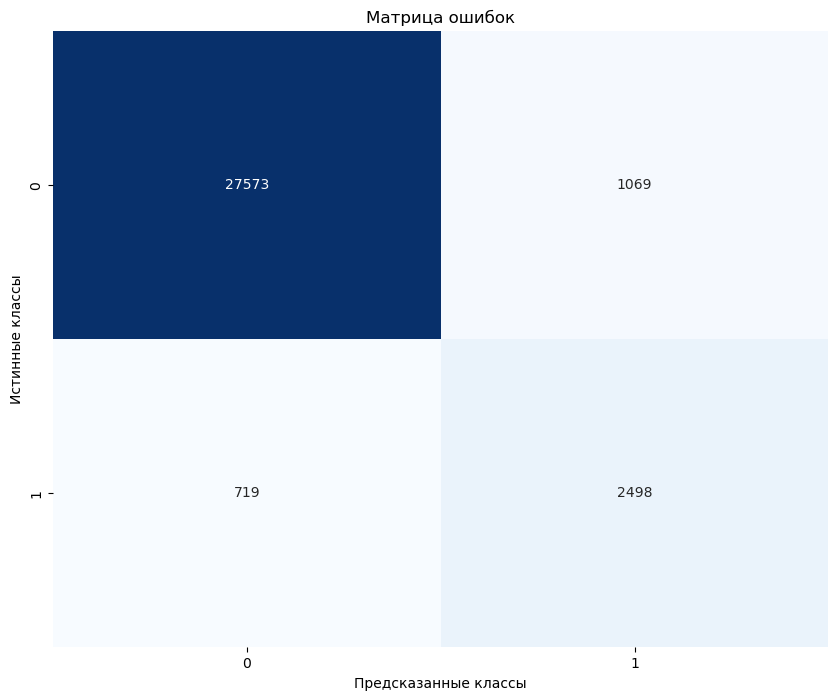

In [96]:
confusion_matrix_plot(y_test, y_predicted_counts)

**Дальнейшая проверка**

Давайте посмотрим на слова, которые наш классификатор использует для принятия решений.

In [128]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

In [132]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Не токсичные', fontsize=16)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=16)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Токсичные', fontsize=16)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=16)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

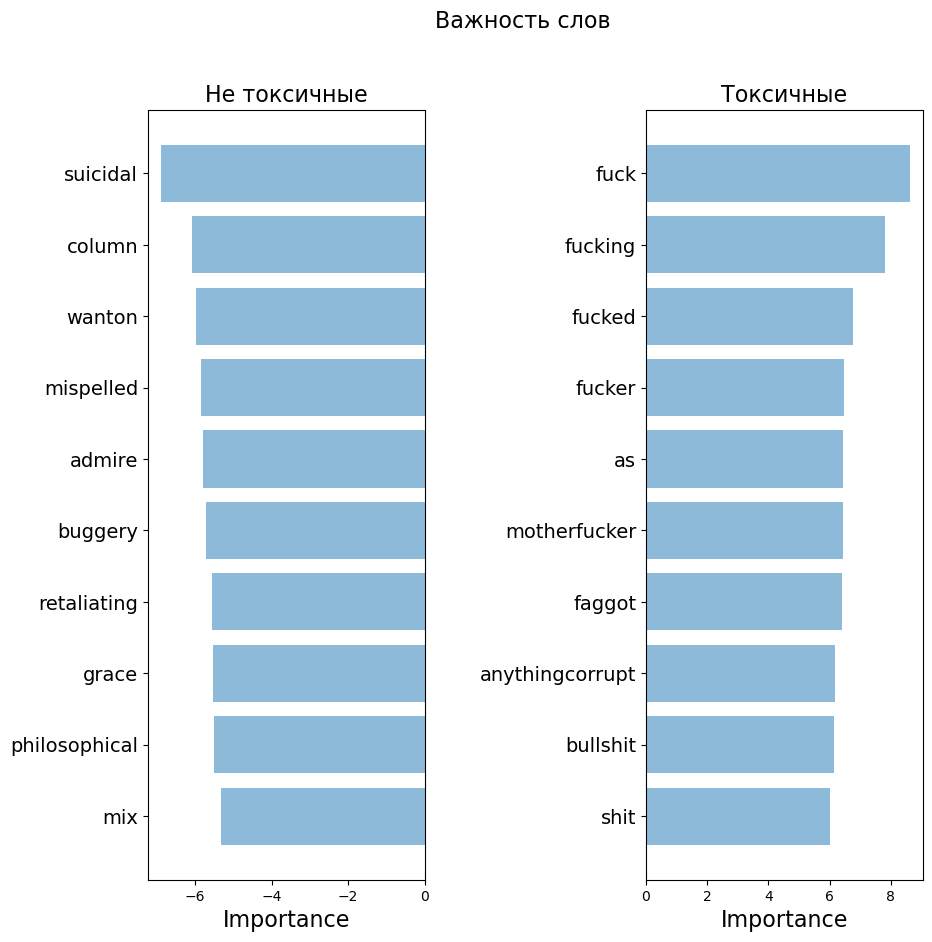

In [133]:
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Важность слов")

### 4.3 TF-DF

In [177]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()
    train = tfidf_vectorizer.fit_transform(data)
    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

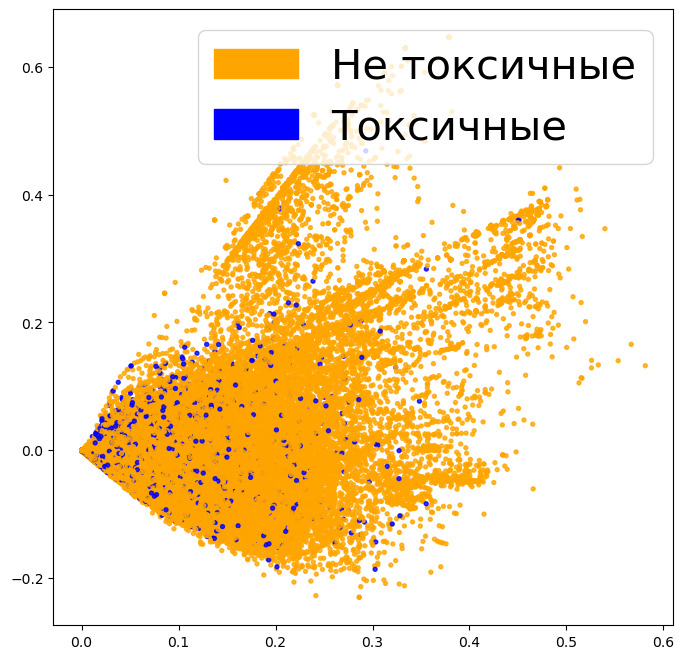

In [180]:
fig = plt.figure(figsize=(8, 8))          
plot_LSA(X_train_tfidf, y_train)
plt.show()

*Данные по прежнему не очень хорошо разделяются*

In [181]:
%%time
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                               multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

CPU times: total: 31.2 ms
Wall time: 10.6 s


LogisticRegression(C=30.0, class_weight='balanced', multi_class='multinomial',
                   n_jobs=-1, random_state=40, solver='newton-cg')

In [182]:
%%time
y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

CPU times: total: 0 ns
Wall time: 8 ms


In [183]:
best_tfdf_accuracy = round(f1_score(y_test, y_predicted_tfidf),4)
print(f"f1-мера лучшей модели: {best_tfdf_accuracy}")

report_tfdf_str = classification_report(y_test, y_predicted_tfidf)
non_empty_lines = [line for line in report_tfdf_str.split('\n') if line.strip()]
print("метрики модели классификации:")

tfdf_table = [row.split() for row in non_empty_lines]
print(tabulate(tfdf_table, headers='firstrow', tablefmt='fancy_grid'))

f1-мера лучшей модели: 0.7674
метрики модели классификации:
╒══════════╤═════════════╤══════════╤════════════╤═══════════╕
│          │ precision   │   recall │   f1-score │   support │
╞══════════╪═════════════╪══════════╪════════════╪═══════════╡
│ 0        │ 0.98        │     0.97 │       0.97 │  28642    │
├──────────┼─────────────┼──────────┼────────────┼───────────┤
│ 1        │ 0.74        │     0.79 │       0.77 │   3217    │
├──────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy │ 0.95        │ 31859    │            │           │
├──────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro    │ avg         │     0.86 │       0.88 │      0.87 │
├──────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted │ avg         │     0.95 │       0.95 │      0.95 │
╘══════════╧═════════════╧══════════╧════════════╧═══════════╛


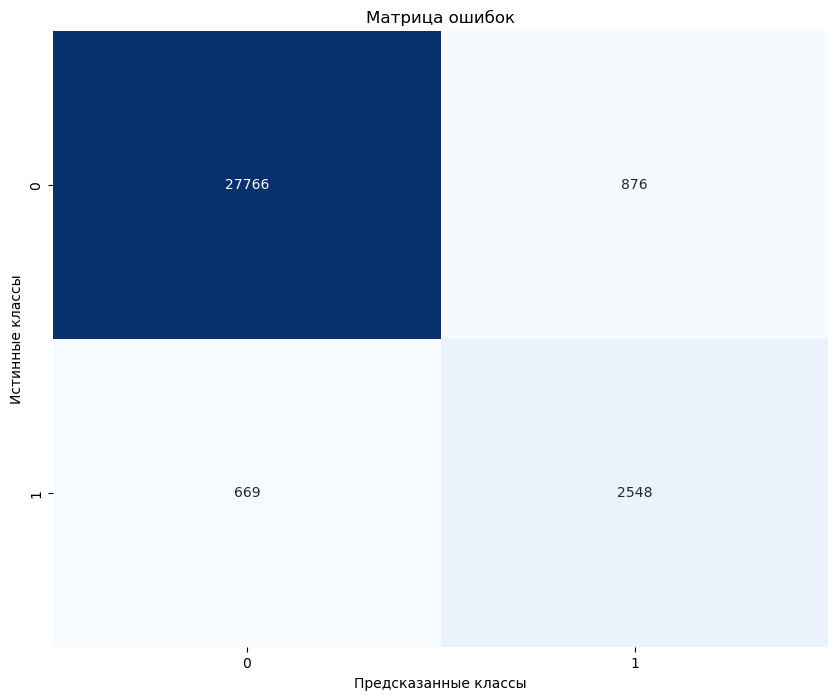

In [138]:
confusion_matrix_plot(y_test, y_predicted_tfidf)

*Результат немного лучше, доля ошибок снизилась*

Посмотрим на значимые слова:

In [139]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

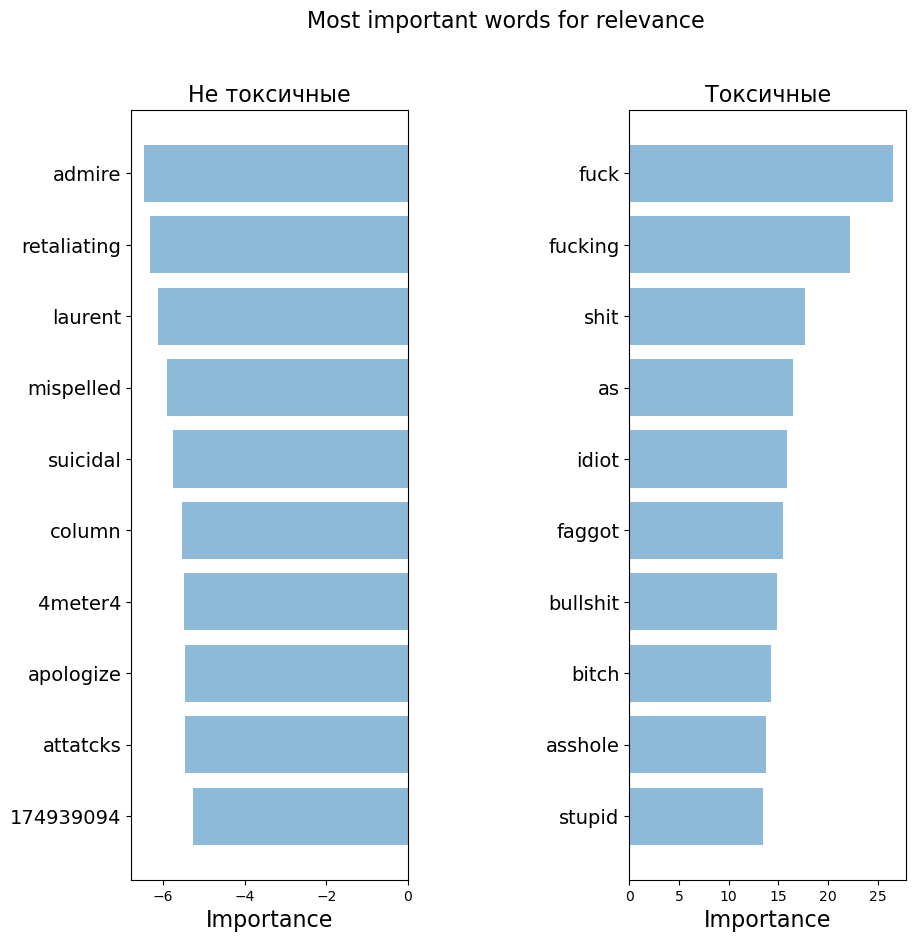

In [140]:
top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

*Результат стал немного лучше, но данные по прежнемуможно улучшить*

## Вывод

Сравнение моделей:

|Название модели| f-1 | Время обучения, с | Время предсказания, мс |
|------------|----------|-------------------|-----------------------|
|LinearRegression| 0.74 | 182 | 5 |
|TF-DF| 0.77 | 11 | 8 |

1. Мы проанализировали DataFrame с данными комментариев.
2. Составили модели машинного обучения на основе методов линейной регрессии и TF-DF
3. Провели тест составленных алгоритмов.
<br>f-1 составил: 0.74 и 0.77 соответственно.